<h1>Data Collection from APIs</h1>

To begin with, we will take a look at Bangalore on the Map using the folium library.

We will also fetch the data from two different APIs.

- <b>Foursquare API</b>: We will use the Foursquare API to fetch venues in Chandigarh starting from the middle upto 44 Kilometers in each direction.

- <b>Zomato API</b>: The Zomato API provides information about various venues including the complete address, user ratings, price for two people, price range and a lot more.

### Bangalore

<b>Bangalore</b> is composed of a number of sectors spread across a total area of 709 sq Km. There are many venues (especially restaurants, hotels and cafes) which can be explored.

The latitude and longitude values of Bangalore are <b>12.9716, 77.5946</b> respectively

In [1]:
import folium
BNG_LATITUDE = 12.9716
BNG_LONGITUDE = 77.5946

bangalore_map = folium.Map(location = [BNG_LATITUDE, BNG_LONGITUDE], zoom_start = 13)
folium.Marker([BNG_LATITUDE, BNG_LONGITUDE]).add_to(bangalore_map)
bangalore_map

## Foursquare API

We begin by fetching a total of all venues in Bangalore upto a range of 5 Kilometers using the Foursquare API. The Foursquare API has the explore API which allows us to find venue recommendations within a given radius from the given coordinates. We will use this API to find all the venues we need.

In [3]:
FOURSQUARE_CLIENT_ID = 'FUXH0QITQXCWMIAKSL5YW3TMXC3Y0GK0BDVS3M0JAB1YCIUX'
FOURSQUARE_CLIENT_SECRET = '2GF3ZADZZMVTVHNMUP2LJHLJBU55Z0A2HGJSGVGFUXI2YSBN'
RADIUS = 5000 # 10 Km
NO_OF_VENUES = 100
VERSION = '20200129' # Current date

In [4]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from pandas.io.json import json_normalize
import requests

pd.set_option('display.max_rows', None)

offset = 0
total_venues = 0
foursquare_venues = pd.DataFrame(columns = ['name', 'categories', 'lat', 'lng'])

while (True):
    url = ('https://api.foursquare.com/v2/venues/explore?client_id={}'
           '&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}').format(FOURSQUARE_CLIENT_ID, 
                                                                        FOURSQUARE_CLIENT_SECRET, 
                                                                        VERSION, 
                                                                        BNG_LATITUDE, 
                                                                        BNG_LONGITUDE, 
                                                                        RADIUS,
                                                                        NO_OF_VENUES,
                                                                        offset)
    result = requests.get(url).json()
    venues_fetched = len(result['response']['groups'][0]['items'])
    total_venues = total_venues + venues_fetched
    print("Total {} venues fetched within a total radius of {} Km".format(venues_fetched, RADIUS/1000))

    venues = result['response']['groups'][0]['items']
    venues = json_normalize(venues)

    # Filter the columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    venues = venues.loc[:, filtered_columns]

    # Filter the category for each row
    venues['venue.categories'] = venues.apply(get_category_type, axis = 1)

    # Clean all column names
    venues.columns = [col.split(".")[-1] for col in venues.columns]
    foursquare_venues = pd.concat([foursquare_venues, venues], axis = 0, sort = False)
    
    if (venues_fetched < 100):
        break
    else:
        offset = offset + 100

foursquare_venues = foursquare_venues.reset_index(drop = True)
print("\nTotal {} venues fetched".format(total_venues))

Total 100 venues fetched within a total radius of 5.0 Km
Total 100 venues fetched within a total radius of 5.0 Km
Total 37 venues fetched within a total radius of 5.0 Km

Total 237 venues fetched


## Zomato API

The Zomato API allows using its search API to search for any given venue based on certain search filters such as query, latitude, longitude and more. Zomato also requires a Zomato user key which can be accessed with a developer account.

We'll use the name, lat, and lng values of various venues fetched from Foursquare API to use the search API and get more information regarding each venue.

- The query will be the name of the venue.
- The start defines from what offset we want to start, so we'll keep it at 0.
- The count defines the number of restaurants we want to fetch. As we have the exact location coordinates, we'll fetch only one.
- We will supply the latitude and longitude values.
- We will set the sorting criteria as real_distance so each time we get the venue we're searching based on location coordinates.

In [6]:
headers = {'user-key': 'ebe563fda333af90fd419bef7b091032'}
venues_information = []

for index, row in foursquare_venues.iterrows():
    print("Fetching data for venue: {}".format(index + 1))
    venue = []
    url = ('https://developers.zomato.com/api/v2.1/search?q={}' + 
          '&start=0&count=1&lat={}&lon={}&sort=real_distance').format(row['name'], row['lat'], row['lng'])
    result = requests.get(url, headers = headers).json()
    if (len(result['restaurants']) > 0):
        venue.append(result['restaurants'][0]['restaurant']['name'])
        venue.append(result['restaurants'][0]['restaurant']['location']['latitude'])
        venue.append(result['restaurants'][0]['restaurant']['location']['longitude'])
        venue.append(result['restaurants'][0]['restaurant']['average_cost_for_two'])
        venue.append(result['restaurants'][0]['restaurant']['price_range'])
        venue.append(result['restaurants'][0]['restaurant']['user_rating']['aggregate_rating'])
        venue.append(result['restaurants'][0]['restaurant']['location']['address'])
        venues_information.append(venue)
    else:
        venues_information.append(np.zeros(6))
    
zomato_venues = pd.DataFrame(venues_information, 
                                  columns = ['venue', 'latitude', 
                                             'longitude', 'price_for_two', 
                                             'price_range', 'rating', 'address'])

Fetching data for venue: 1
Fetching data for venue: 2
Fetching data for venue: 3
Fetching data for venue: 4
Fetching data for venue: 5
Fetching data for venue: 6
Fetching data for venue: 7
Fetching data for venue: 8
Fetching data for venue: 9
Fetching data for venue: 10
Fetching data for venue: 11
Fetching data for venue: 12
Fetching data for venue: 13
Fetching data for venue: 14
Fetching data for venue: 15
Fetching data for venue: 16
Fetching data for venue: 17
Fetching data for venue: 18
Fetching data for venue: 19
Fetching data for venue: 20
Fetching data for venue: 21
Fetching data for venue: 22
Fetching data for venue: 23
Fetching data for venue: 24
Fetching data for venue: 25
Fetching data for venue: 26
Fetching data for venue: 27
Fetching data for venue: 28
Fetching data for venue: 29
Fetching data for venue: 30
Fetching data for venue: 31
Fetching data for venue: 32
Fetching data for venue: 33
Fetching data for venue: 34
Fetching data for venue: 35
Fetching data for venue: 36
F

## Data Cleaning

The data from multiple resources might not always align. Thus, it is important to combine the data retrieved from multiple resources properly.

We'll first plot the two data points on the map. We'll then try to combine data points that have their latitude and longitude values very close to one another. From the remaining selected venues, we will inspect the venues to ensure that any remaining mismatched venues are also removed from the final dataset of venues before we begin any analysis.

We will first plot the Foursquare data on the map.

In [8]:
bangalore_map = folium.Map(location = [BNG_LATITUDE, BNG_LONGITUDE], zoom_start = 13)

for name, latitude, longitude in zip(foursquare_venues['name'], foursquare_venues['lat'], foursquare_venues['lng']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'green',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(bangalore_map)  

bangalore_map

### We will also plot the Zomato data on the map.

In [14]:
bangalore_map = folium.Map(location = [12.9716, 77.5946], zoom_start = 13)

for venue, address, latitude, longitude in zip(zomato_venues['venue'], zomato_venues['address'], 
                                               zomato_venues['latitude'].astype(float), zomato_venues['longitude'].astype(float)):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'red',
        fill = True,
        fill_color = '#cc3535',
        fill_opacity = 0.7,
        parse_html = False).add_to(bangalore_map)  


bangalore_map

To combine the two datasets, I'll have to check that the latitude and longitude values of each corresponding venue match. Thus, I'll round both the latitude and longitude values upto 4 decimal places. Then, I'll calculate the difference between the corresponding latitude and longitude values and see if the difference is less than 0.0004 which should ideally mean that the two locations are same.

In [29]:
foursquare_venues['lat'] = foursquare_venues['lat'].apply(lambda lat: round(float(lat), 4))
foursquare_venues['lng'] = foursquare_venues['lng'].apply(lambda lng: round(float(lng), 4))
zomato_venues['latitude'] = zomato_venues['latitude'].apply(lambda lat: round(float(lat), 4))
zomato_venues['longitude'] = zomato_venues['longitude'].apply(lambda lng: round(float(lng), 4))

In [30]:
dataset = pd.concat([foursquare_venues, zomato_venues], axis = 1)
dataset['lat_diff'] = dataset['latitude'] - dataset['lat']
dataset['lng_diff'] = dataset['longitude'] - dataset['lng']

In [31]:
selected_venues = dataset[(abs(dataset['lat_diff']) <= 0.0004) & (abs(dataset['lng_diff']) <= 0.0004)].reset_index(drop = True)
selected_venues

,name,categories,lat,lng,venue,latitude,longitude,price_for_two,price_range,rating,address,lat_diff,lng_diff
0,JW Marriott Hotel Bengaluru,Hotel,12.9724,77.5951,Merak-JW Marriott Hotel,12.9724,77.5951,1200.0,3.0,0,"JW Marriott, 24/1, Vittal Mallya Road, Lavelle...",0.0000,0.0000
1,UB City,Shopping Mall,12.9717,77.5959,Shiro,12.9718,77.5959,3000.0,4.0,4.4,"2nd Floor, UB City Mall, Vittal Mallya Road, L...",0.0001,0.0000
2,Toscano,Italian Restaurant,12.9720,77.5961,Toscano,12.9719,77.5964,2400.0,4.0,4.4,"2nd Floor, UB City, Vittal Mallya Road, Lavell...",-0.0001,0.0003
3,Café Noir,French Restaurant,12.9720,77.5960,Cafe Noir,12.9721,77.5964,1500.0,3.0,4.2,"2nd Floor, UB City, Vittal Mallya Road, Lavell...",0.0001,0.0004
4,Shiro,Japanese Restaurant,12.9719,77.5962,Shiro,12.9718,77.5959,3000.0,4.0,4.4,"2nd Floor, UB City Mall, Vittal Mallya Road, L...",-0.0001,-0.0003
5,Smoke House Deli,Deli / Bodega,12.9717,77.5983,Smoke House Deli,12.9717,77.5983,1600.0,3.0,4.6,"52/ 53, Ground Floor, Lavelle Road, Bangalore",0.0000,0.0000
6,Skyye,Lounge,12.9716,77.5962,Skyye,12.9716,77.5964,2500.0,4.0,4.2,"Uber Level, 16th Floor, UB City, Vittal Mallya...",0.0000,0.0002
7,Harima,Sushi Restaurant,12.9678,77.6001,Harima,12.9675,77.5999,2000.0,4.0,4.3,"131, 4th Floor, Devatha Plaza, Residency Road,...",-0.0003,-0.0002
8,Truffles - Ice & Spice,Burger Joint,12.9718,77.6010,Truffles,12.9718,77.6011,900.0,2.0,4.5,"22, St. Marks Road, Bangalore",0.0000,0.0001
9,Corner House,Ice Cream Shop,12.9730,77.6000,Corner House Ice Cream,12.9732,77.6000,350.0,1.0,4.4,"4, Madras Bank Road, Lavelle Road, Bangalore",0.0002,0.0000


In [32]:
selected_venues['average_price'] = selected_venues['price_for_two']/2
selected_venues = selected_venues.drop(columns = ['name', 'lat', 'lng', 'lat_diff', 'lng_diff', 'price_for_two'])

In [33]:
selected_venues.head(5)

,categories,venue,latitude,longitude,price_range,rating,address,average_price
0,Hotel,Merak-JW Marriott Hotel,12.9724,77.5951,3.0,0,"JW Marriott, 24/1, Vittal Mallya Road, Lavelle...",600.0
1,Shopping Mall,Shiro,12.9718,77.5959,4.0,4.4,"2nd Floor, UB City Mall, Vittal Mallya Road, L...",1500.0
2,Italian Restaurant,Toscano,12.9719,77.5964,4.0,4.4,"2nd Floor, UB City, Vittal Mallya Road, Lavell...",1200.0
3,French Restaurant,Cafe Noir,12.9721,77.5964,3.0,4.2,"2nd Floor, UB City, Vittal Mallya Road, Lavell...",750.0
4,Japanese Restaurant,Shiro,12.9718,77.5959,4.0,4.4,"2nd Floor, UB City Mall, Vittal Mallya Road, L...",1500.0


I'll drop the venues which have 0.0 rating as it means it's not been rated yet.

In [34]:
selected_venues = selected_venues[selected_venues['rating'] != 0.0]
print("Total venues available: {}".format(selected_venues.shape[0]))

Total venues available: 163


## Methodology

This project aims at identifying the venues in Bangalore based on their rating and average costs. This would enable any visitor to identify the venues he/she wants to visit based on their rating and cost preference.

As a first step, we retrieved the data from two APIs (Foursquare and Zomato). We extract venue information from the center of Chandigarh, upto a distance of 4 Km. The latitude and longitude values are then used to fetch venue rating and price from Zomato.

Secondly, we then explored the data retrieved from the two APIs on the map and identified the top category types. The data from the two sources is carefully combined based on the name, latitude and longitude values from the two sources. The final dataset would include the rating and price values for each venue.

Next, we'll analyse the data that we created based on the ratings and price of each venue. We'll identify places where many venues are located so that any visitor can go to one place and enjoy the option to choose amongst many venue options. We'll also explore areas that are high rated and those that are low rated while also plotting the map of high and low priced venues. Lastly, we'll cluster the venues based on the available information of each venue. This will allow us to clearly identify which venues can be recommended and with what characteristics.

Finally, we'll discuss and conclude which venues to be explored based on visitor requirement of rating and cost.

## Analysis

The complete dataset is now in its final form.

We will inspect these venues based on their rating. The rating of a venue are based on user reviews and belongs to a range from 1 to 5. We'll also analyse the venues based on their price per person as well as the price range.

## Categories

We have various types of venues in the final dataset. We will take a look at the venues and check which are the majority venue categories in the list.

<BarContainer object of 65 artists>

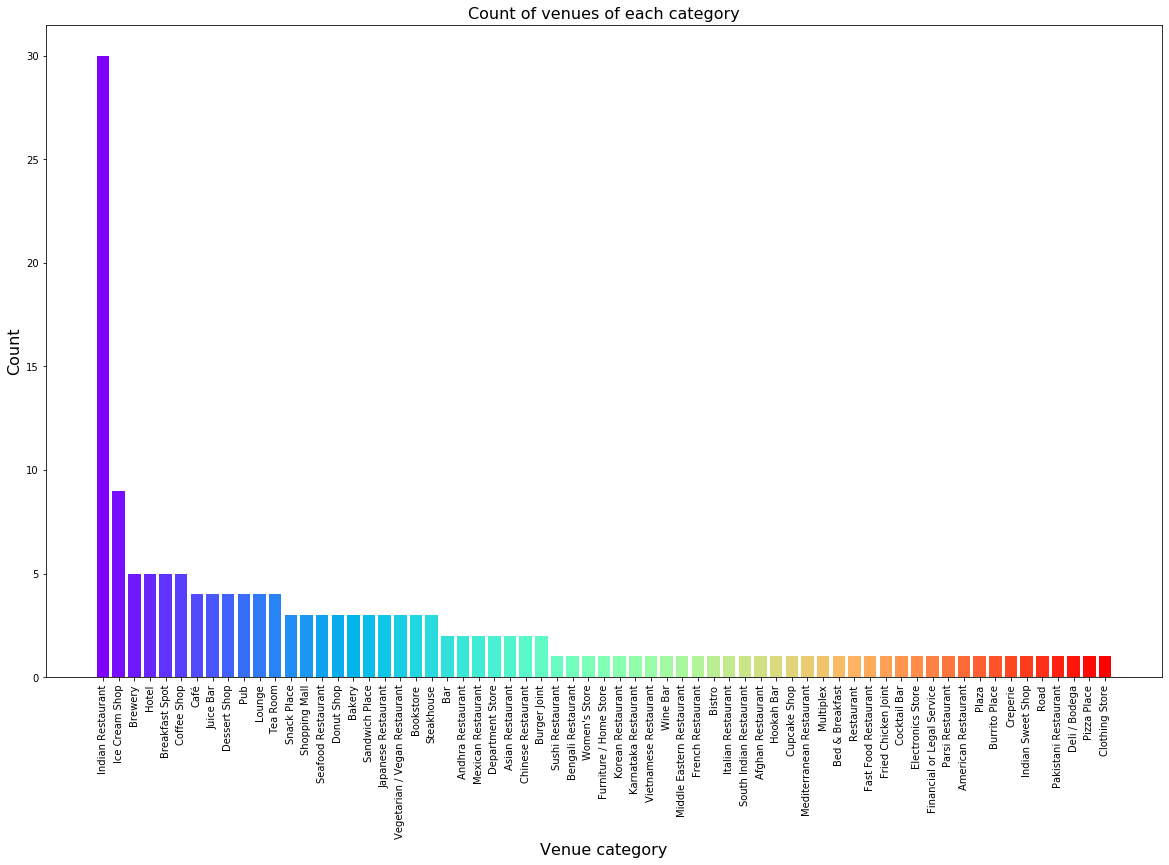

In [35]:
venue_distribution = selected_venues['categories'].value_counts()
colors = cm.rainbow(np.linspace(0, 1, len(venue_distribution.index)))
plt.figure(figsize = (20, 12))
plt.xticks(rotation = 90)
plt.xlabel("Venue category", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues of each category", fontsize = 16)
plt.bar(venue_distribution.index, venue_distribution.values, color = colors)

As we can see the majority venues are Indian Restaurant and Ice Cream Shops. So, if as a tourist, you're looking for Indian restaurants and Ice Cream shops, you're in luck.

## Ratings

Rating of a venue is an important factor on which a visitor decides whether it is worth it to visit the place. To cater to this, we will first see what is the average rating for all the venues in the city. Next, we will plot the venues on the map and color code them.

We'll first identify the various rating values and plot them as a bar plot with their counts to see the most common rating.

Text(0.5, 1.0, 'Count of venues with given rating')

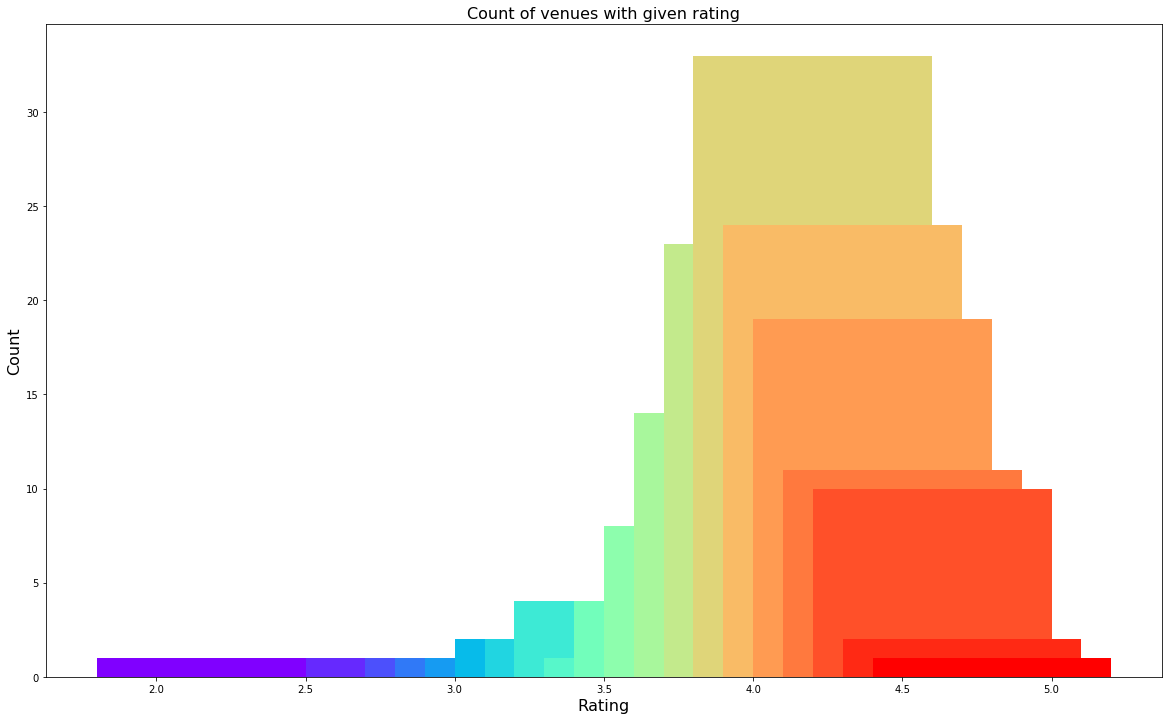

In [36]:
selected_venues['rating'] = selected_venues['rating'].astype(float)
rating = selected_venues['rating'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.bar(rating.index, rating.values, color = cm.rainbow(np.linspace(0, 1, len(rating.index))))
plt.xlabel("Rating", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues with given rating", fontsize = 16)

From the plot above, it is clear that majority venues have their rating close to 4.

Let's create bins for various ratings and plot them in different colors on the map. The ratings will be divided between 4 bins:

- 1 to 2
- 2 to 3
- 3 to 4
- 4 to 5

In [37]:
bins = [1.0, 2.0, 3.0, 4.0, 5.0]
labels = ['Low', 'Okay', 'Good', 'Very good']
selected_venues['rating_bin'] = pd.cut(selected_venues['rating'].astype(float), bins = bins, labels = labels, include_lowest = True)

In [24]:
color_map = {'Low': 'red', 'Okay': 'orange', 'Good': 'green', 'Very good': 'darkgreen'}

bangalore_map = folium.Map(location = [BNG_LATITUDE, BNG_LONGITUDE], zoom_start = 13)

for name, address, latitude, longitude, rating_bin in zip(selected_venues['venue'], 
                                                          selected_venues['address'], 
                                                          selected_venues['latitude'], 
                                                          selected_venues['longitude'], 
                                                          selected_venues['rating_bin']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[rating_bin]),
        popup = label).add_to(bangalore_map)  

bangalore_map

## Price

We will now take a look the venues based on the price values. We have two price features for our venues, one is average_price which defines the average cost for one person and the other is price_range which determines the price range as defined by Zomato.

We will first explore the average_price using a scatter plot between the price and the count of venues with that average price. We'll size the points based on the price to highlight their price.

Text(0.5, 1.0, 'Count of venues with given average price')

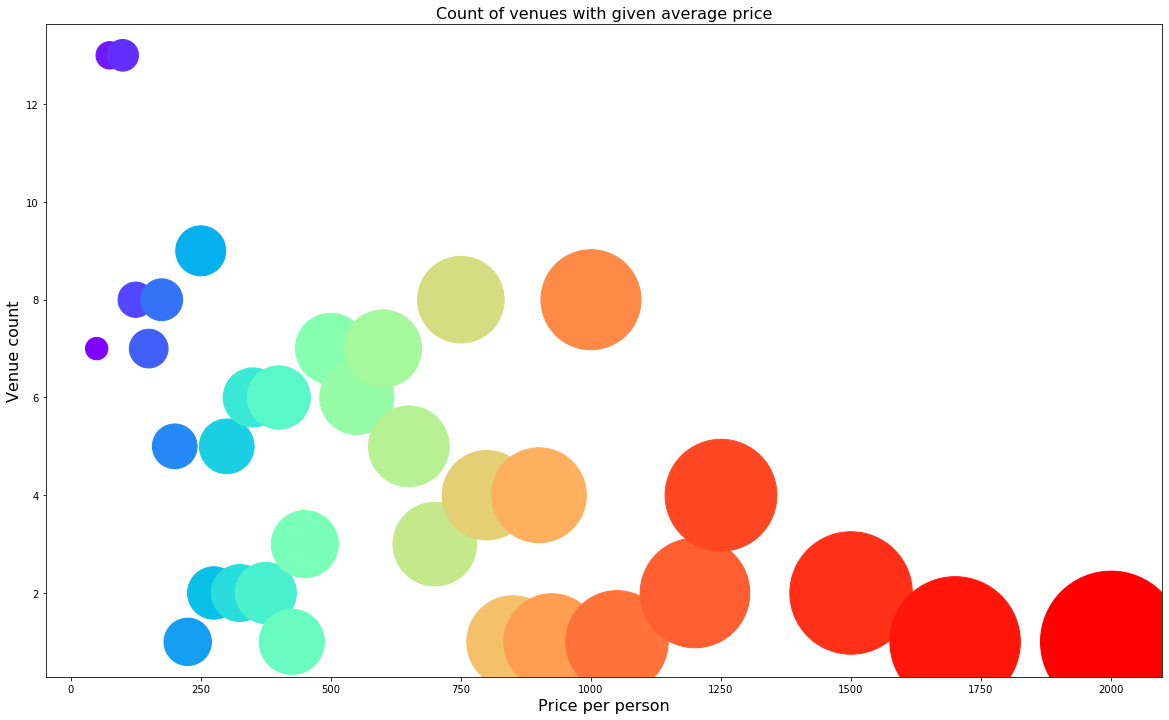

In [38]:
average_prices = selected_venues['average_price'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.scatter(average_prices.index, 
            average_prices.values, 
            s = average_prices.index*10, 
            c = cm.rainbow(np.linspace(0, 1, len(average_prices.index))))
plt.xlabel("Price per person", fontsize = 16)
plt.ylabel("Venue count", fontsize = 16)
plt.title("Count of venues with given average price", fontsize = 16)

From the plot above we can see that a large number of venues have an average price between Rs 250 and Rs 1000.

Users might also be interested in going to a place that fits in their budget. I'll use the price_range column to plot the venues on a map. We'll represent the venues with lower price in green and move towards red as the price increases.

In [39]:
color_map = {'1.0': 'green', '2.0': 'darkgreen', '3.0': 'orange', '4.0': 'red'}

bangalore_map = folium.Map(location = [BNG_LATITUDE, BNG_LONGITUDE], zoom_start = 13)

for name, address, latitude, longitude, price_range in zip(selected_venues['venue'], 
                                                           selected_venues['address'], 
                                                           selected_venues['latitude'], 
                                                           selected_venues['longitude'], 
                                                           selected_venues['price_range'].astype(str)):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[price_range]),
        popup = label).add_to(bangalore_map)  


bangalore_map

The venues near Malleshwaram and VV puram are primarily lower priced.

The venues near MG Road have steep prices.

Kormangala seems to have a mix of both high priced and low priced venues.

# Clustering

We will now cluster all these venues based on their price range, location and more to identify similar venues and the relationship amongst them. We'll cluster the venues into two separate groups.

In [40]:
from sklearn.cluster import KMeans

NO_OF_CLUSTERS = 2

clustering = selected_venues.drop(['venue', 'address', 'rating_bin', 'categories'], 1)
kMeans = KMeans(n_clusters = NO_OF_CLUSTERS, random_state = 0).fit(clustering)
selected_venues.insert(0, 'cluster_labels', kMeans.labels_)
selected_venues.head(5)

,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
1,1,Shopping Mall,Shiro,12.9718,77.5959,4.0,4.4,"2nd Floor, UB City Mall, Vittal Mallya Road, L...",1500.0,Very good
2,1,Italian Restaurant,Toscano,12.9719,77.5964,4.0,4.4,"2nd Floor, UB City, Vittal Mallya Road, Lavell...",1200.0,Very good
3,1,French Restaurant,Cafe Noir,12.9721,77.5964,3.0,4.2,"2nd Floor, UB City, Vittal Mallya Road, Lavell...",750.0,Very good
4,1,Japanese Restaurant,Shiro,12.9718,77.5959,4.0,4.4,"2nd Floor, UB City Mall, Vittal Mallya Road, L...",1500.0,Very good
5,1,Deli / Bodega,Smoke House Deli,12.9717,77.5983,3.0,4.6,"52/ 53, Ground Floor, Lavelle Road, Bangalore",800.0,Very good


In [43]:
bangalore_map = folium.Map(location = [BNG_LATITUDE, BNG_LONGITUDE], zoom_start = 13)
color_map = { 0: 'green', 1: 'red'}

# add venues to the map
markers_colors = []
for venue, address, cluster, latitude, longitude in zip(selected_venues['venue'], 
                                                        selected_venues['address'], 
                                                        selected_venues['cluster_labels'], 
                                                        selected_venues['latitude'], 
                                                        selected_venues['longitude']):
    label = folium.Popup(str(venue) + ', ' + str(address), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = color_map[cluster],
        fill = True,
        fill_color = color_map[cluster],
        fill_opacity = 0.7).add_to(bangalore_map)

# add cluster centers to the map
for index, cluster in enumerate(kMeans.cluster_centers_):
    latitude = cluster[0]
    longitude = cluster[1]
    label = folium.Popup("Cluster: " + str(index), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 10,
        popup = label,
        color = color_map[index],
        fill = True,
        fill_color = color_map[index],
        fill_opacity = 0.7).add_to(bangalore_map)


bangalore_map

From the map, we see the two clusters:

- The first cluster is spread across the whole city and includes the majority venues.
- The second cluster is very sparsely spread and has very limited venues.

I'll also check the venues of the two clusters.

In [45]:
result = selected_venues[selected_venues['cluster_labels'] == 0]
print("Cluster 0")
result.head(10).reset_index(drop = True)

Cluster 0


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,0,Burger Joint,Truffles,12.9718,77.6011,2.0,4.5,"22, St. Marks Road, Bangalore",450.0,Very good
1,0,Ice Cream Shop,Corner House Ice Cream,12.9732,77.6000,1.0,4.4,"4, Madras Bank Road, Lavelle Road, Bangalore",175.0,Very good
2,0,Breakfast Spot,Pizza Stop,12.9730,77.6001,2.0,3.6,"Airlines Hotel, 4, Madras Bank Road, Lavelle R...",300.0,Good
3,0,Ice Cream Shop,Natural Ice Cream,12.9714,77.6010,1.0,4.2,"20, Ground Floor, 15/16, House Of Lords, St. M...",100.0,Very good
4,0,Plaza,Lakeview Milkbar,12.9760,77.6038,2.0,4.0,"89, Kannan Building, MG Road, Bangalore",250.0,Good
5,0,Fried Chicken Joint,Kentacky Chicken Corner,12.9663,77.5952,1.0,4.1,"10, Sampangi Tank Road, Richmond Road, Bangalore",150.0,Very good
6,0,Bookstore,20 Feet High,12.9750,77.6050,3.0,4.0,"22, Amoeba Complex, Church Street, Bangalore",500.0,Good
7,0,Pub,Smally's Resto Cafe,12.9755,77.6026,2.0,4.2,"46, Church Street, Bangalore",325.0,Very good
8,0,Indian Restaurant,MTR 1924,12.9722,77.6009,1.0,4.2,"29, Ground Floor, White House, St. Marks Road,...",150.0,Very good
9,0,Brewery,RS Shiv Sagar Express,12.9685,77.6017,1.0,3.8,"Near Cash Pharmacy, Residency Road, Bangalore",150.0,Good


In [46]:
print("These venues for cluster 0 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 0 have mean price range of 1.56 and rating spread around 4.11


In [47]:
result = selected_venues[selected_venues['cluster_labels'] == 1]
print("Cluster 1")
result.head(10).reset_index(drop = True)

Cluster 1


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,1,Shopping Mall,Shiro,12.9718,77.5959,4.0,4.4,"2nd Floor, UB City Mall, Vittal Mallya Road, L...",1500.0,Very good
1,1,Italian Restaurant,Toscano,12.9719,77.5964,4.0,4.4,"2nd Floor, UB City, Vittal Mallya Road, Lavell...",1200.0,Very good
2,1,French Restaurant,Cafe Noir,12.9721,77.5964,3.0,4.2,"2nd Floor, UB City, Vittal Mallya Road, Lavell...",750.0,Very good
3,1,Japanese Restaurant,Shiro,12.9718,77.5959,4.0,4.4,"2nd Floor, UB City Mall, Vittal Mallya Road, L...",1500.0,Very good
4,1,Deli / Bodega,Smoke House Deli,12.9717,77.5983,3.0,4.6,"52/ 53, Ground Floor, Lavelle Road, Bangalore",800.0,Very good
5,1,Lounge,Skyye,12.9716,77.5964,4.0,4.2,"Uber Level, 16th Floor, UB City, Vittal Mallya...",1250.0,Very good
6,1,Sushi Restaurant,Harima,12.9675,77.5999,4.0,4.3,"131, 4th Floor, Devatha Plaza, Residency Road,...",1000.0,Very good
7,1,Brewery,The Biere Club,12.9712,77.5976,3.0,4.3,"20/2, Vittal Mallya Road, Lavelle Road, Bangalore",850.0,Very good
8,1,American Restaurant,Hard Rock Cafe,12.9760,77.6016,4.0,4.5,"40, Opposite LIC Building, Off MG Road, St. Ma...",1250.0,Very good
9,1,Cupcake Shop,Skyye,12.9716,77.5964,4.0,4.2,"Uber Level, 16th Floor, UB City, Vittal Mallya...",1250.0,Very good


In [48]:
print("These venues for cluster 1 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 1 have mean price range of 3.37 and rating spread around 4.28


## Results and Discussion 
Based on our analysis above, we can draw a number of conclusions that will be useful to aid any visitor visiting the city of Bangalore, India.

After collecting data from the Foursquare and Zomato APIs, we got a list of 237 different venues. However, not all venues from the two APIs were identical. Hence, we had to inspect their latitude and longitude values as well as names to combine them and remove all the outliers. 

We identified that from the total set of venues, majority of them were Indian Restaurants and Ice Cream Shops. A visitor who loves ndian Restaurants/ Ice Cream shops would surely benefit from coming to Bangalore.

While the complete range of ratings range from 1 to 5, the majority venues have ratings close to 4. This means that most restaurants provide good quality food which is liked by the people of the city, thus indicating the high rating. When we plot these venues on the map, we discover that there are clusters of venues around Kormangala, VV puram and MG Road. These clusters also have very high ratings (more than 3).

When we take a look at the price values of each venue, we explore that many venues have prices which are in the range of Rs 250 to Rs 800 for one person. However, the variation in prices is very large, given the complete range starts from Rs 100 and goes uptil Rs 1500. On plotting the venues based on their price range on the map, we discovered that venues located near VV puram and Malleshwaram are relatively priced lower than venues in MG Road and Koramangala. A mix of low price and high price exist in Koramangala.

Finally, through clusters we identified that there are many venues which are relatively lower priced but have an average rating of 3.57. On the other hand, there are few venues which are high priced and have average rating of 4.03.

If you're looking for cheap places with relatively high rating, you should check VV puram.
If you're looking for the best places, with the highest rating but might also carry a high price tag, you should visit MG Road.
If you're looking to explore the city and have no specific criteria to decide upon the places you want to visit, you should try Koramangala.
A company can use this information to build up an online website/mobile application, to provide users with up to date information about various venues in the city based on the search criteria (name, rating and price).

### Conclusion 
The purpose of this project was to explore the places that a person visiting Bangalore could visit. The venues have been identified using Foursquare and Zomato API and have been plotted on the map. The map reveals that there are three major areas a person can visit: Sector 35, Sector 7 & 26 and Elante Mall. Based on the visitor's venue rating and price requirements, he/she can choose amongst the three places.